# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Review the first few rows of the data set
raw_df.head()

,0,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [4]:
# Check size of the data set
raw_df.shape

(461, 4)

In [5]:
# Check for null values
raw_df.isnull().sum()

0             0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

## Data Cleaning

In [6]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

Unspecified                       127
Loan Default                      114
Loan default                       75
Debt yield fall                    34
Debt Yield Fall                    25
DSCR Fall                          17
Operator Termination               13
Mezzanine Default                  12
Bankruptcy                         12
Mezzanine Outstanding              10
Mezzanine default                   8
Aggregate debt yield fall           6
Aggregate Debt Yield Fall           3
Tenant Failure                      2
Debt yield fall | Loan default      1
Aggregate debt yield                1
Aggregate DSCR Fall                 1
Name: Trigger, dtype: int64

In [7]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [8]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Loan Default                      189
Unspecified                       127
Debt Yield Fall                    59
Mezzanine Default                  20
Dscr Fall                          17
Operator Termination               13
Bankruptcy                         12
Mezzanine Outstanding              10
Aggregate Debt Yield Fall           9
Tenant Failure                      2
Aggregate Dscr Fall                 1
Debt Yield Fall | Loan Default      1
Aggregate Debt Yield                1
Name: Trigger, dtype: int64

In [9]:
# Rename first column (document title)
raw_df = raw_df.rename(columns = {'0': 'Document'})

In [10]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [11]:
raw_df.shape

(461, 3)

In [12]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

13 unique documents have been included in the data set


In [13]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    65
20180125_02FE6L_Prospectus_SD000000002394837596.pdf    44
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    43
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf    42
20170525_02DFUI_Prospectus_SD000000002352389122.pdf    37
20170727_02DTVX_Prospectus_SD000000002362015714.pdf    35
20171019_02EFSE_Prospectus_SD000000002376978886.pdf    35
20170814_02E227_Prospectus_SD000000002367167139.pdf    34
20150307_028S2X_Prospectus_SD000000002389024187.pdf    29
20170801_02DX5C_Prospectus_SD000000002363000910.pdf    28
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf    25
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    24
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf    20
Name: Document, dtype: int64

In [14]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have trigger counts that range from {min_triggers} to {max_triggers}.')

The 13 Documents have trigger counts that range from 20 to 65.


In [15]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    422
True      39
Name: is_duplicate, dtype: int64

In [16]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 39 row duplicates in the data set.


In [17]:
# We'll remove the extra duplicate rows
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [18]:
raw_df.shape

(422, 3)

In [19]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [20]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Loan Default                      180
Unspecified                       119
Debt Yield Fall                    48
Mezzanine Default                  17
Dscr Fall                          16
Operator Termination               11
Bankruptcy                          9
Aggregate Debt Yield Fall           9
Mezzanine Outstanding               8
Tenant Failure                      2
Aggregate Dscr Fall                 1
Debt Yield Fall | Loan Default      1
Aggregate Debt Yield                1
Name: Trigger, dtype: int64

In [21]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    65
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    38
20171019_02EFSE_Prospectus_SD000000002376978886.pdf    35
20180125_02FE6L_Prospectus_SD000000002394837596.pdf    34
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf    34
20170525_02DFUI_Prospectus_SD000000002352389122.pdf    33
20170814_02E227_Prospectus_SD000000002367167139.pdf    31
20170727_02DTVX_Prospectus_SD000000002362015714.pdf    29
20150307_028S2X_Prospectus_SD000000002389024187.pdf    29
20170801_02DX5C_Prospectus_SD000000002363000910.pdf    27
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf    25
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    22
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf    20
Name: Document, dtype: int64

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [22]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [23]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [24]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,debt_yield_fall_|_loan_default
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
df.dtypes

Document                          object
Sentence                          object
loan_default                       Int64
aggregate_dscr_fall                Int64
dscr_fall                          Int64
unspecified                        Int64
debt_yield_fall                    Int64
aggregate_debt_yield_fall          Int64
mezzanine_default                  Int64
tenant_failure                     Int64
mezzanine_outstanding              Int64
operator_termination               Int64
bankruptcy                         Int64
aggregate_debt_yield               Int64
debt_yield_fall_|_loan_default     Int64
dtype: object

In [26]:
df.shape

(349, 15)

In [27]:
# We can confirm that the number of Triggers is consistent with the prior dataframe
df.sum()

Document                          20120828_01Y0R8_Prospectus_CM00000000205875087...
Sentence                          On each Business Day, the financial institutio...
loan_default                                                                    180
aggregate_dscr_fall                                                               1
dscr_fall                                                                        16
unspecified                                                                     119
debt_yield_fall                                                                  48
aggregate_debt_yield_fall                                                         9
mezzanine_default                                                                17
tenant_failure                                                                    2
mezzanine_outstanding                                                             8
operator_termination                                                        

## Feature Engineering

In [28]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [29]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,debt_yield_fall_|_loan_default,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,1772
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,235


In [30]:
# We confirm that if a sentence is Unspecified, there are no other loan events
df[df['unspecified']==1].sum()

Document                          20150307_028S2X_Prospectus_SD00000000238902418...
Sentence                          Except during a Cash Management Period, funds ...
loan_default                                                                      0
aggregate_dscr_fall                                                               0
dscr_fall                                                                         0
unspecified                                                                     119
debt_yield_fall                                                                   0
aggregate_debt_yield_fall                                                         0
mezzanine_default                                                                 0
tenant_failure                                                                    0
mezzanine_outstanding                                                             0
operator_termination                                                        

## Natural Language Processing of the sentence column

In [31]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [32]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [33]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [34]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [35]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [36]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,debt_yield_fall_|_loan_default,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [37]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [38]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [39]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [40]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

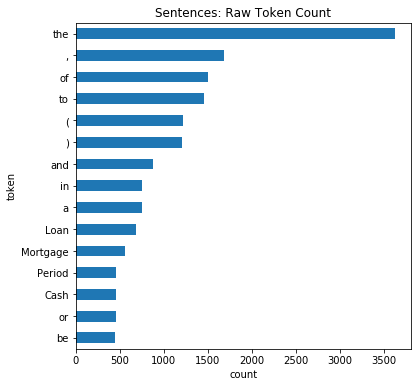

In [41]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

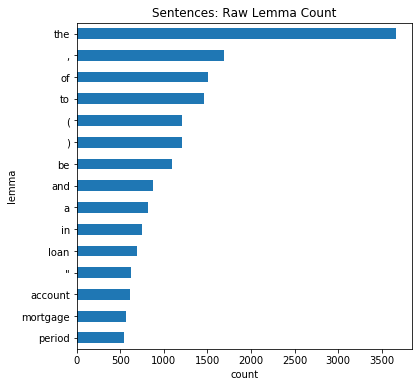

In [42]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [43]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [44]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

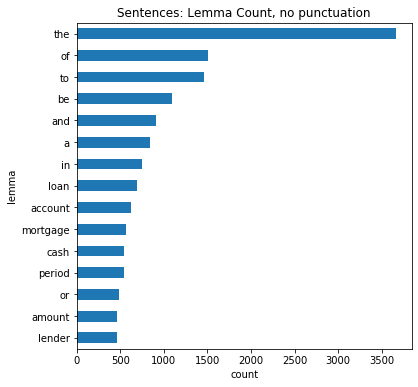

In [45]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [46]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [47]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [48]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [49]:
short_stopwords = ['the', 'of', 'to', 'be', 'and', 'a', 'in']

In [50]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['should',
 'get',
 'here',
 'some',
 'thence',
 'even',
 'under',
 'about',
 'everywhere',
 'take',
 'either',
 'across',
 'that',
 'four',
 'side',
 'together',
 'meanwhile',
 'neither',
 'from',
 'at',
 'often',
 'really',
 'being',
 'toward',
 'seem',
 'other',
 'could',
 'these',
 'those',
 'mostly',
 'though',
 'regarding',
 'everything',
 'whereupon',
 'can',
 'you',
 'almost',
 'whatever',
 'would',
 'formerly',
 'no',
 'not',
 'hereafter',
 'call',
 'former',
 'make',
 'latter',
 'done',
 'hers',
 'whole',
 'ten',
 'we',
 'by',
 'sixty',
 'has',
 'few',
 'does',
 'hundred',
 'more',
 'seeming',
 'with',
 'down',
 'it',
 'nobody',
 'as',
 'because',
 'among',
 'six',
 'again',
 'how',
 'move',
 'which',
 'anywhere',
 'am',
 'becomes',
 'once',
 'someone',
 'behind',
 'of',
 'or',
 'what',
 'yet',
 'whereby',
 'been',
 'beforehand',
 'although',
 'myself',
 'anyhow',
 'have',
 'however',
 'already',
 'ever',
 'such',
 'themselves',
 'for',
 'forty',
 'through',
 'rather',
 'whoe

In [51]:
# Choose to exclude anything with numbers are might be particularly relevant
to_exclude = ['thereupon', 'cannot', 'should'] 

In [52]:
# Define our selected stopword lists 
select_stopwords = [word for word in stopwords if word not in to_exclude]
select_stopwords

['get',
 'here',
 'some',
 'thence',
 'even',
 'under',
 'about',
 'everywhere',
 'take',
 'either',
 'across',
 'that',
 'four',
 'side',
 'together',
 'meanwhile',
 'neither',
 'from',
 'at',
 'often',
 'really',
 'being',
 'toward',
 'seem',
 'other',
 'could',
 'these',
 'those',
 'mostly',
 'though',
 'regarding',
 'everything',
 'whereupon',
 'can',
 'you',
 'almost',
 'whatever',
 'would',
 'formerly',
 'no',
 'not',
 'hereafter',
 'call',
 'former',
 'make',
 'latter',
 'done',
 'hers',
 'whole',
 'ten',
 'we',
 'by',
 'sixty',
 'has',
 'few',
 'does',
 'hundred',
 'more',
 'seeming',
 'with',
 'down',
 'it',
 'nobody',
 'as',
 'because',
 'among',
 'six',
 'again',
 'how',
 'move',
 'which',
 'anywhere',
 'am',
 'becomes',
 'once',
 'someone',
 'behind',
 'of',
 'or',
 'what',
 'yet',
 'whereby',
 'been',
 'beforehand',
 'although',
 'myself',
 'anyhow',
 'have',
 'however',
 'already',
 'ever',
 'such',
 'themselves',
 'for',
 'forty',
 'through',
 'rather',
 'whoever',
 'ple

## Train/Test Split

In [53]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,debt_yield_fall_|_loan_default,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [54]:





X = df['SentenceLemmas']
y = df['bankruptcy']

y = y.astype('int')

In [55]:
y.dtypes

dtype('int64')

In [56]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (349,)
y shape is (349,)


In [57]:
y.value_counts()

0    340
1      9
Name: bankruptcy, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(261,) (261,)
(88,) (88,)


In [59]:
X.head()

0    on each business day , the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas, dtype: object

In [60]:
X_train.shape[0]

261

In [61]:
y_train.shape[0]

261

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [62]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), ],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],  
    'cvec__max_features': [30, 40, 50, 60, 70, 80, 90, 100],
#    'cvec__min_df': [2],
#    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 39.731


In [63]:
#log_reg = LogisticRegression()
#logreg.fit(X_train, y_train)


In [64]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 1.000
Test score is 0.989
Cross Validation score is 0.971
Seconds elapsed for score calculation: 0.464


In [65]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.973
Best Parameters :{'cvec__max_features': 50, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None}


### 2: TFIDF + Logistic Regression GridSearch and modeling

In [66]:
# Define TFIDF + Logistic Regression Pipeline

pipe_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter = 4000, random_state = RANDOM_STATE))])

tfidf_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],  
    'tfidf__max_features': [30, 40, 50, 60, 70, 80, 90, 100, 200],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 3, scoring = 'accuracy')

results_tfidf = gs_tfidf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 89.817


In [67]:
t0 = time.time()
print(f'Training score is {results_tfidf.score(X_train, y_train):.3f}')
print(f'Test score is {results_tfidf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_tfidf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.973
Test score is 0.977
Cross Validation score is 0.974
Seconds elapsed for score calculation: 0.344


In [68]:
print(f'Best Score: {results_tfidf.best_score_}')
print(f'Best Parameters: {results_tfidf.best_params_}')

Best Score: 0.9731800766283526
Best Parameters: {'tfidf__max_features': 30, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}


### 3: CountVectorizer + Multinomial Naive Bayes GridSearch & modeling

In [69]:
# Define CountVectorizer + Multinomial Naive Bayes Grisearch pipeline

pipe_mnb = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])
mnb_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],
    'cvec__max_features': [30, 40, 50, 60, 70, 80, 90, 100, 200],
#    'cvec__min_df': [3],
#    'cvec__max_df': [ .99],
    }

gs_mnb = GridSearchCV(pipe_mnb, param_grid = mnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_mnb = gs_mnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 85.758


In [70]:
t0 = time.time()
print(f'Training score is {results_mnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_mnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_mnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.904
Test score is 0.852
Cross Validation score is 0.897
Seconds elapsed for score calculation: 0.297


In [71]:
print(f'Best Score: {results_mnb.best_score_}')
print(f'Best Parameters: {results_mnb.best_params_}')

Best Score: 0.9042145593869733
Best Parameters: {'cvec__max_features': 30, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


### 4: TFIDF + Gaussian Naive Bayes GridSearch & modeling

In [72]:
# Define TFIDF + Gaussian Naive Bayes Gridsearch pipeline

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


pipe_gnb = Pipeline([('tfidf', TfidfVectorizer()), ('to_dense', DenseTransformer()),('gnb', GaussianNB())])

gnb_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],
    'tfidf__max_features': [50, 60, 70, 80, 90, 100, 200, 400, 600],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_gnb = GridSearchCV(pipe_gnb, param_grid = gnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_gnb = gs_gnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 65.229


In [73]:
t0 = time.time()
print(f'Training score is {results_gnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_gnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_gnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.977
Test score is 0.977
Cross Validation score is 0.963
Seconds elapsed for score calculation: 0.323


In [74]:
print(f'Best Score: {results_gnb.best_score_}')
print(f'Best Parameters: {results_gnb.best_params_}')

Best Score: 0.9655172413793104
Best Parameters: {'tfidf__max_features': 400, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}


## Model Selection
- In this section we compare the Train and Test scores across the various models

In [75]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')

Baseline Score:                                0.977
CountVectorizer + LogisticRegression Accuracy: 1.000
TfidfVectorizer + LogisticRegression Accuracy: 0.973
CountVectorizer + Multinomial Naive Bayes:     0.904
TfidfVectorizer + Gaussian Naive Bayes:        0.977


In [76]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')

Baseline Score:                                0.977
CountVectorizer + LogisticRegression Accuracy: 0.989
TfidfVectorizer + LogisticRegression Accuracy: 0.977
CountVectorizer + Multinomial Naive Bayes:     0.852
TfidfVectorizer + Gaussian Naive Bayes:        0.977


## Model Evaluation

In [77]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [78]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.6178892135683547,
 -0.3959912814987716,
 -0.42218730860722153,
 0.1887387749515052,
 0.4627282257505963,
 -0.17619197392458505,
 -0.8030056948190168,
 0.8117498472673342,
 -0.019759717117847644,
 0.1961159666446459]

In [79]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [80]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = False)

In [81]:
# Display top differentiating words and phrases in predicting Trigger Event
df_cvec_coefs.head(20)

,word,coef
31,or,0.877809
7,borrower,0.811750
22,lender,0.597858
32,payment,0.520788
27,of,0.469963
4,any,0.462728
41,the lender,0.408717
40,the borrower,0.372445
25,mortgage,0.291477
18,for,0.290916


In [82]:
# Top differentiating words and phrases predicting a non-Trigger Event
df_cvec_coefs.tail(20).sort_values('coef', ascending = True)

,word,coef
6,be,-0.803006
39,the,-0.802442
0,account,-0.617889
14,during,-0.597669
21,in the,-0.512805
2,an,-0.422187
1,amount,-0.395991
13,deposit,-0.355206
47,under,-0.322086
15,event,-0.316144


### Calculating predictions and Confusion Matrix

In [83]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [84]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [85]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[85  1]
 [ 0  2]]


In [86]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [87]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,85,1
Actual Positive,0,2


In [88]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)

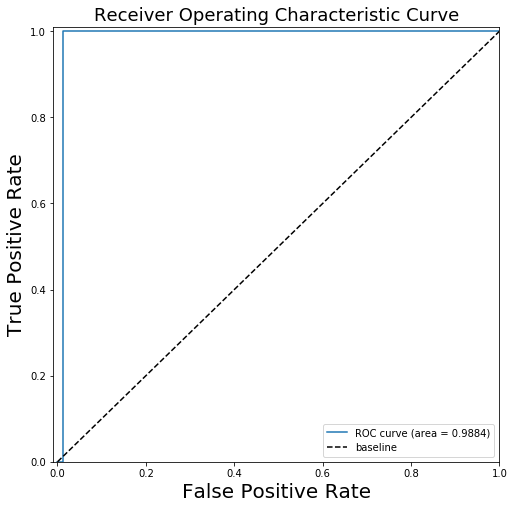

In [89]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [90]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [91]:
result_cols = ['prediction', 'actual', 'Sentence']
results = pd.DataFrame({'prediction': list(preds), 'actual': list(y_test), 'Sentence': list(X_test)})
results.head()

,prediction,actual,Sentence
0,0,0,a cash management period be currently in place due to the existence of mezzanine debt .
1,0,0,"upon the first occurrence of a trigger period , the lender , on the borrower ’s behalf , will establish an eligible account ( the "" cash management account "" ) with an eligible institution ( or the lender or servicer , as applicable ) for the sole and exclusive benefit of the lender ."
2,0,0,"on each loan payment date during the continuance of a trigger period , the borrower be require to fund a tax , insurance and homeowner ’s association fee reserve in an amount equal to one - twelfth of the amount that the lender reasonably estimate will be necessary to pay tax , insurance premium and homeowner ’s association fee over the then succeed 12-month period ."
3,0,0,"upon the occurrence and during the continuance of a cash sweep period ( as define below ) , the borrower be require to establish and maintain a segregated eligible account ( the "" cash management account "" ) to be hold by the mortgage lender ."
4,0,0,"in the event no marriott management period or period in which a qualified replacement hotel operator be not manage the property exist , the borrower will establish and be require to maintain a lockbox account into which income from the property will be deposit ."


In [92]:
misclassified = results[results['prediction'] != results['actual']]


In [93]:
misclassified.head(10)

,prediction,actual,Sentence
74,1,0,"during the continuance of a loan event of default , the lender will have the right , at -PRON- option , to draw on all or any portion of any letter of credit and to apply such amount(s ) draw to the payment of the item for which such letter of credit be establish or to apply each such letter of credit to payment of the whole loan in such order , proportion or priority as the lender may determine ."
